In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/akkirr/annotated-diffusion


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

import torch
from torch import nan_to_num
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import requests

from datasets import load_dataset
from torchvision.utils import save_image
from torch.optim import Adam

In [3]:
from mylib import *
from lora import *

In [4]:
sampler = Sampler(linear_beta_schedule, 300)

In [5]:
# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Found cached dataset fashion_mnist (/home/akkirr/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).filter(lambda x: x['label'] == 0).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

Loading cached processed dataset at /home/akkirr/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e1de293369d54b3d.arrow
Loading cached processed dataset at /home/akkirr/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-99238c540bf086fb.arrow


In [7]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [8]:
results_folder = Path("./results_lora")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

# Lora

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

# Sampling

In [10]:
model.load_state_dict(torch.load('checkpoints/2-trained-on-1:last.pt'))

<All keys matched successfully>

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

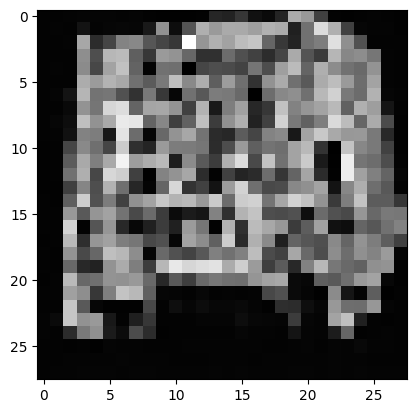

In [11]:
# sample 64 images
torch.manual_seed(0)
samples = sampler.sample(model, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_index = 0
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

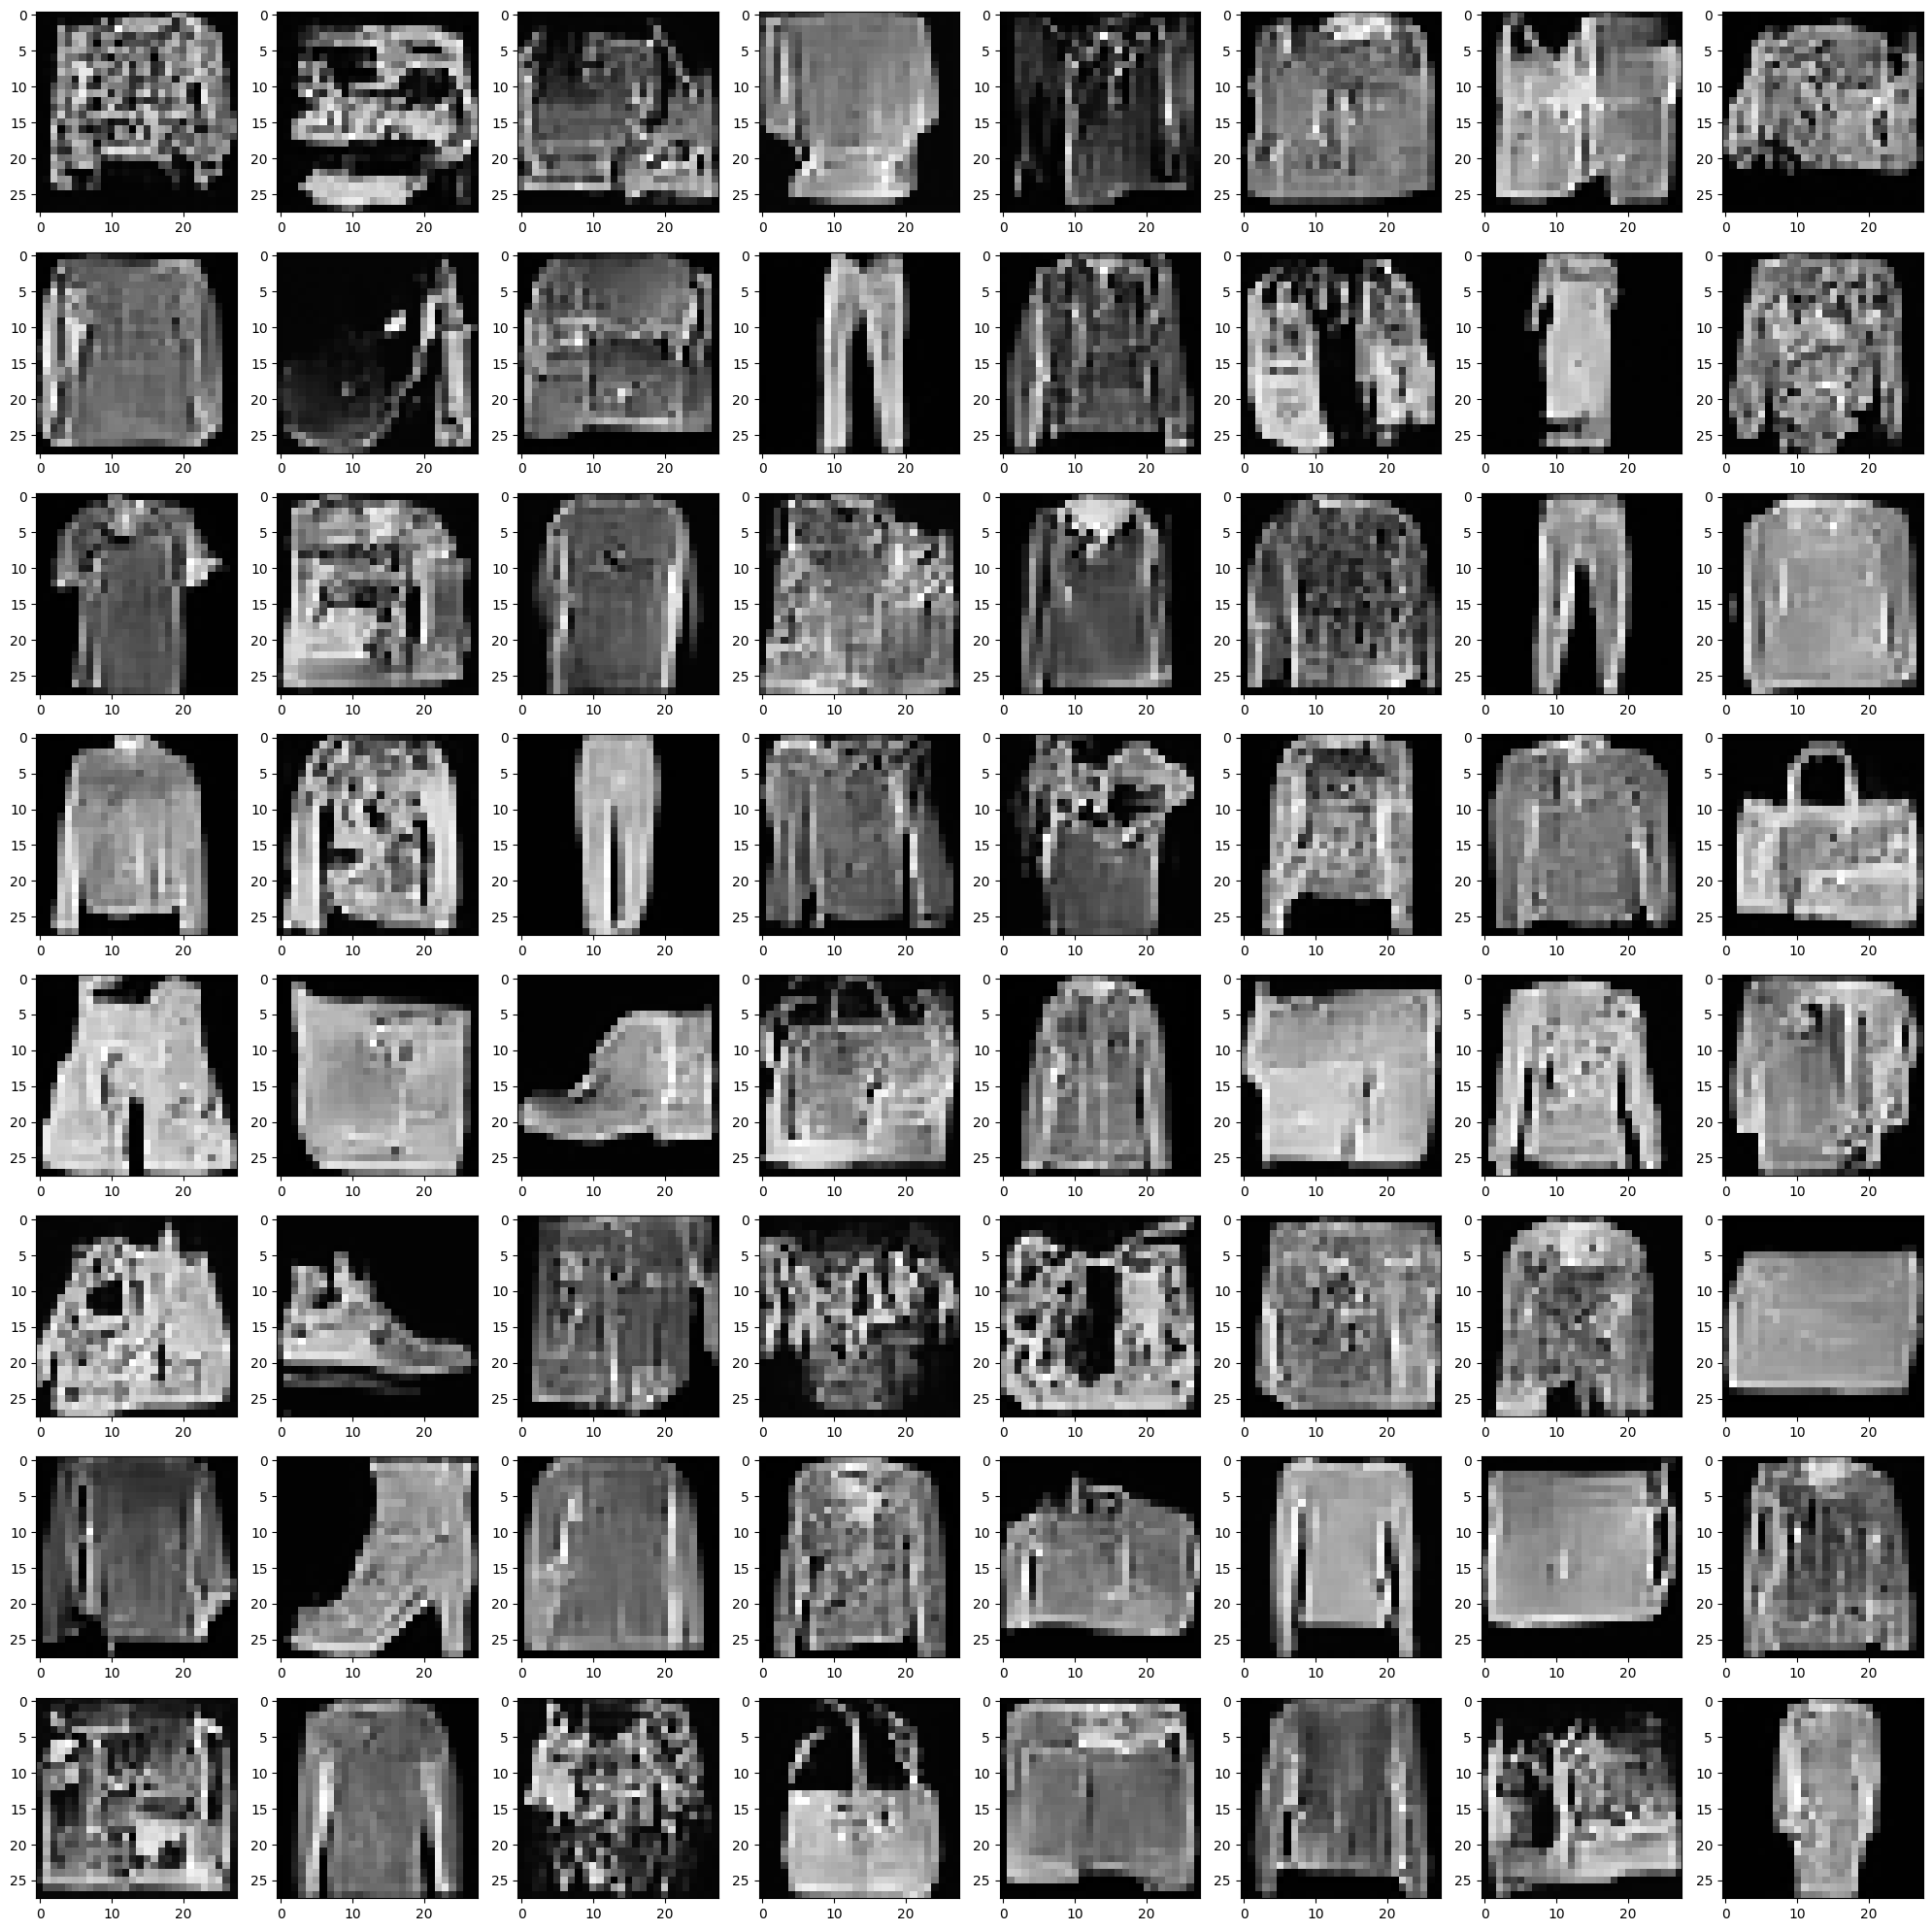

In [12]:
def plot_images(samples, n = 64):
    sqrt = int(n ** 0.5)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    ax = ax.ravel()
    for i in range(n):
        ax[i].imshow(samples[-1][i].reshape(image_size, image_size, channels), cmap="gray")
    plt.tight_layout()
    plt.show()

plot_images(samples)

# Training

In [13]:
from lora import *

In [14]:
inject_lora(model, 1, 0.1,
            ["LinearAttention"],
            [nn.Conv2d],
            verbose=True)

Injected lora (28x1x384) in downs.0.2.fn.fn.to_qkv
Injected lora (128x1x28) in downs.0.2.fn.fn.0
Injected lora (28x1x384) in downs.1.2.fn.fn.to_qkv
Injected lora (128x1x28) in downs.1.2.fn.fn.0
Injected lora (56x1x384) in downs.2.2.fn.fn.to_qkv
Injected lora (128x1x56) in downs.2.2.fn.fn.0
Injected lora (112x1x384) in ups.0.2.fn.fn.to_qkv
Injected lora (128x1x112) in ups.0.2.fn.fn.0
Injected lora (56x1x384) in ups.1.2.fn.fn.to_qkv
Injected lora (128x1x56) in ups.1.2.fn.fn.0
Injected lora (28x1x384) in ups.2.2.fn.fn.to_qkv
Injected lora (128x1x28) in ups.2.2.fn.fn.0


In [15]:
freeze_lora(model)

In [16]:
count_frozen_parameters(model)

trainable :     24
frozen    :    231


In [19]:
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [84]:
epochs = 6
save_and_sample_every = len(dataloader)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, sampler.timesteps, (batch_size,), device=device).long()

      loss = sampler.p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(8, batch_size)
        all_images_list = list(map(lambda n: sampler.sample(model,image_size=image_size, batch_size=n, channels=channels), batches))
        all_images_list = [torch.tensor(x) for x in all_images_list[0]]
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 4)

Loss: 0.03186078742146492
Loss: 0.03785335272550583
Loss: 0.03349493071436882
Loss: 0.03119063377380371
Loss: 0.03301417827606201
Loss: 0.02643752470612526


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

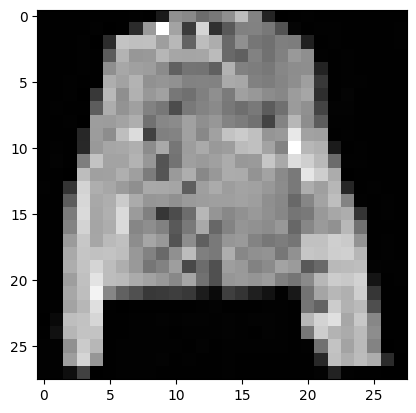

In [85]:
# sample 64 images
torch.manual_seed(0)
samples = sampler.sample(model, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_index = 0
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

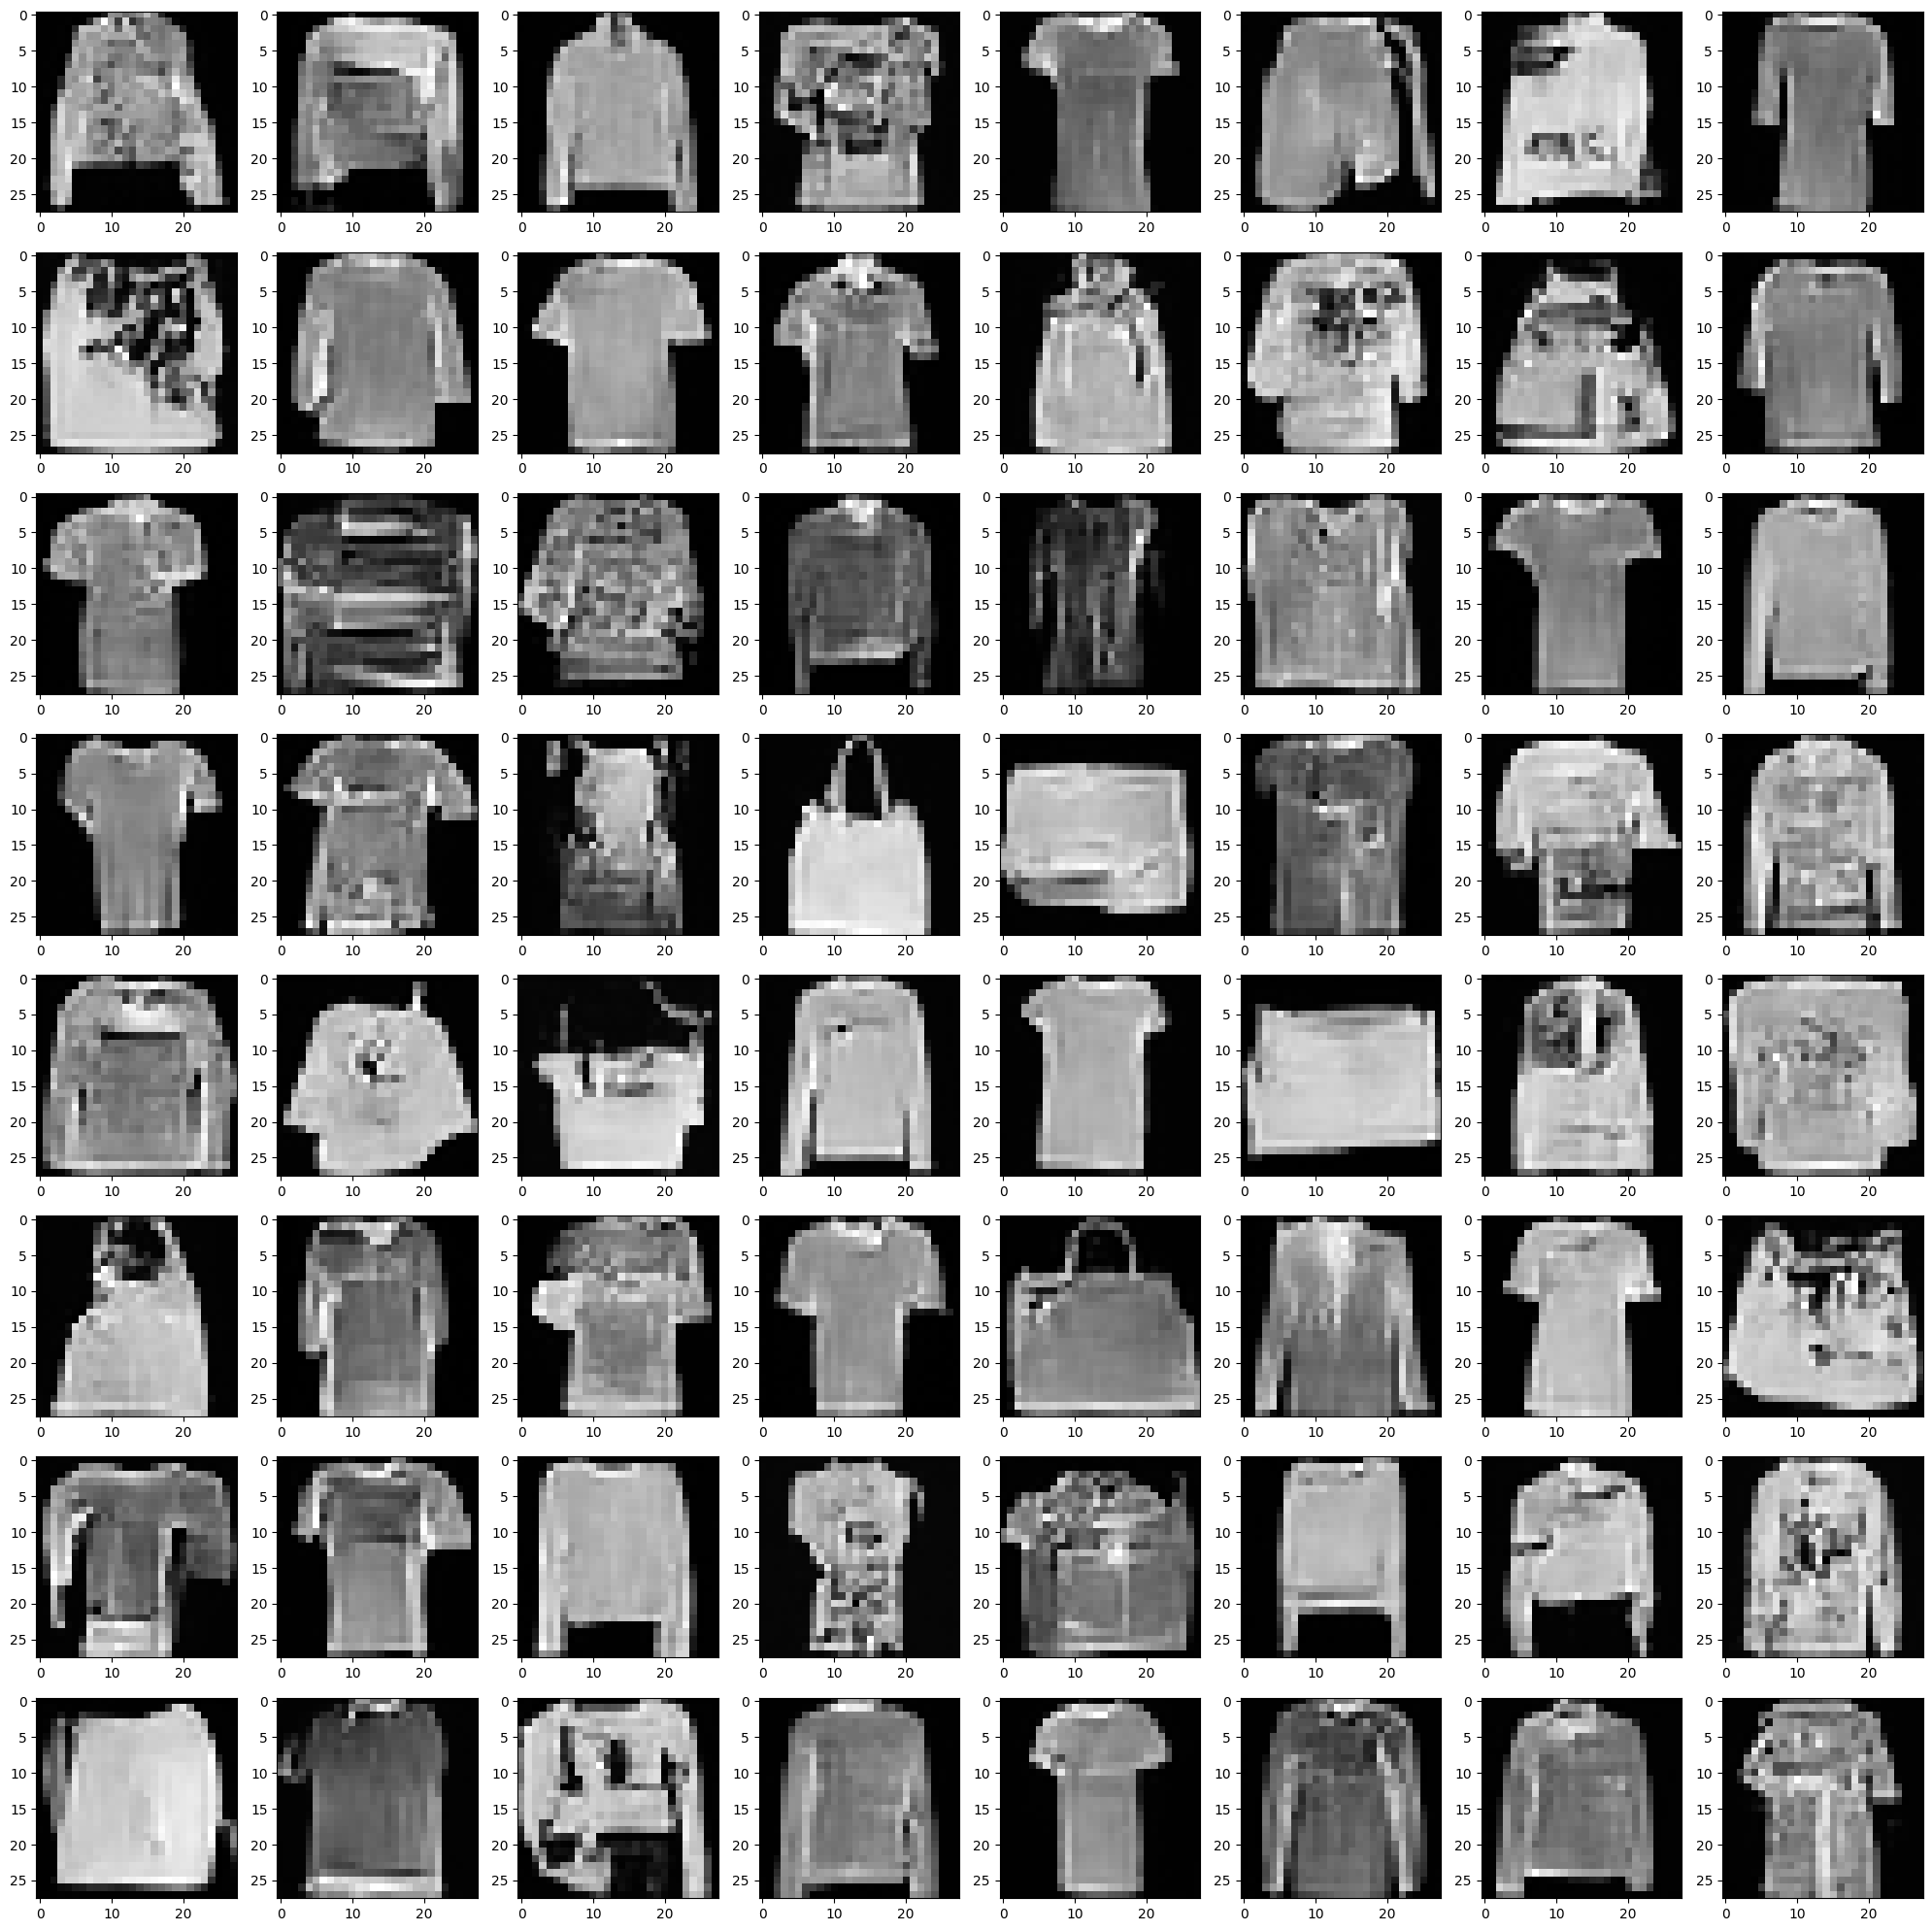

In [86]:
def plot_images(samples, n = 64):
    sqrt = int(n ** 0.5)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    ax = ax.ravel()
    for i in range(n):
        ax[i].imshow(samples[-1][i].reshape(image_size, image_size, channels), cmap="gray")
    plt.tight_layout()
    plt.show()

plot_images(samples)

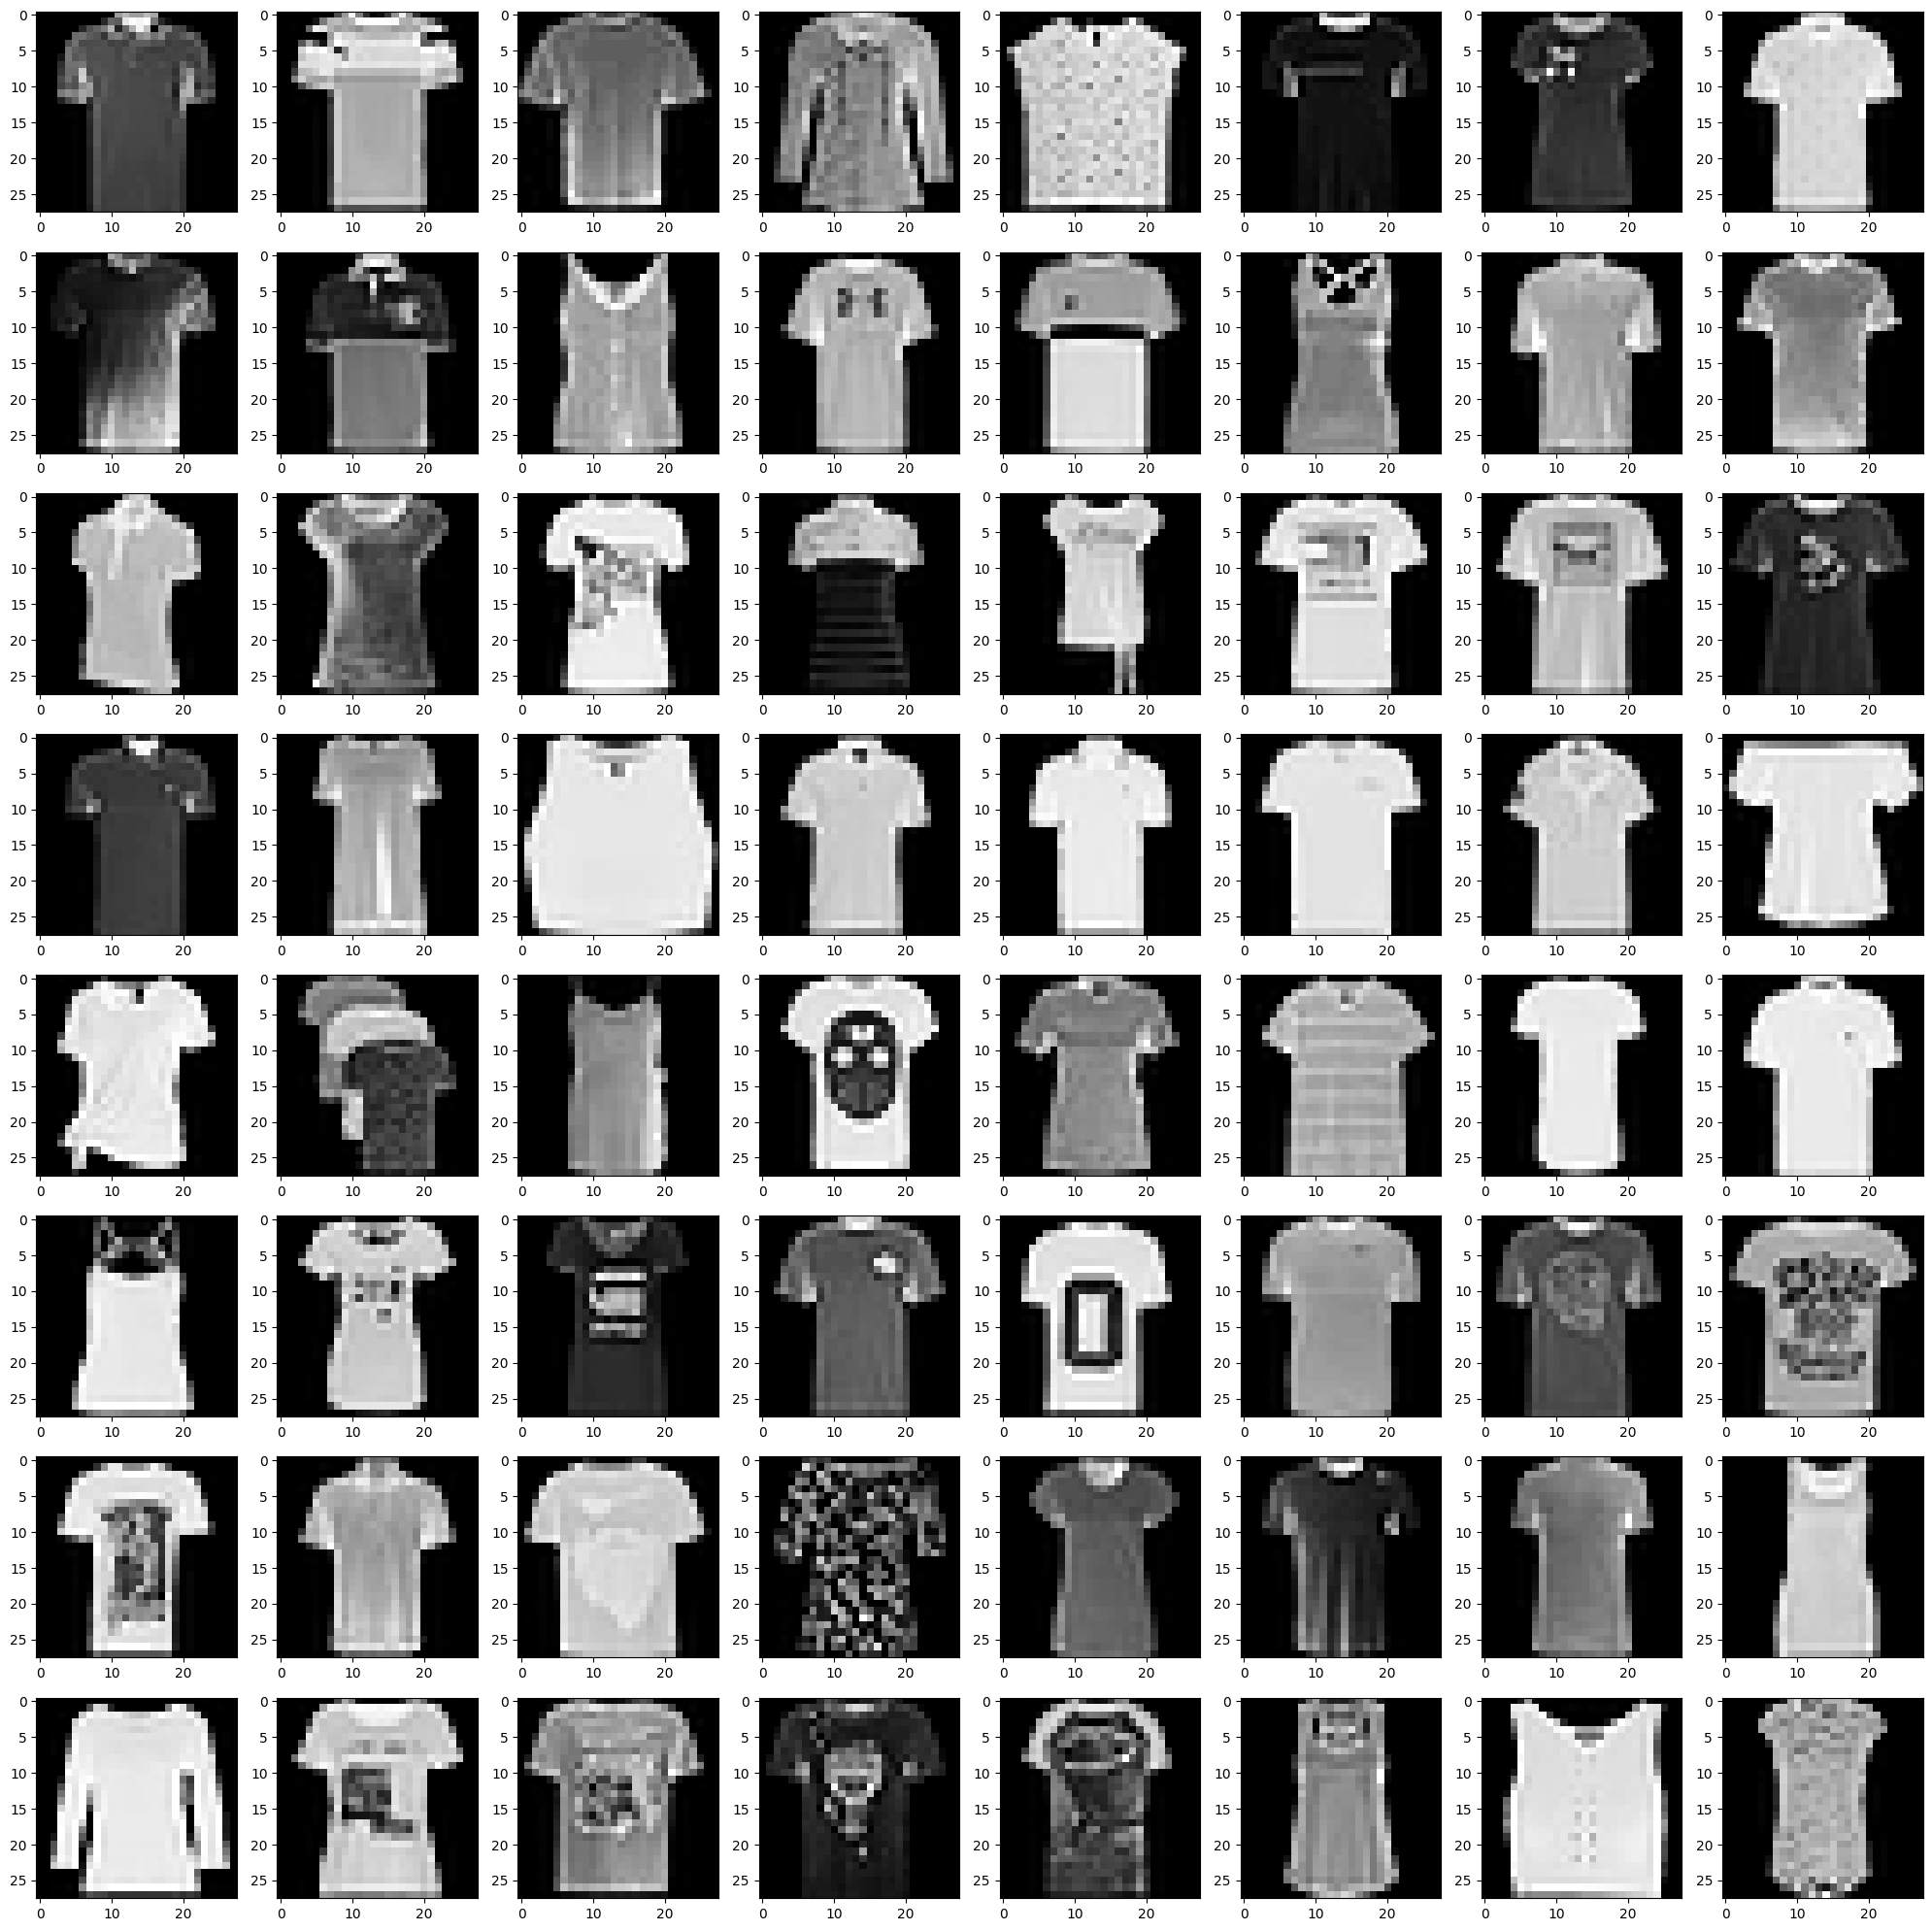

In [78]:
def plot_dataloader(dataloader, n=64):
    batch = next(iter(dataloader))['pixel_values'][:n]
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    ax = ax.ravel()
    for i in range(n):
        ax[i].imshow(batch[i].reshape(image_size, image_size, channels), cmap="gray")
    plt.tight_layout()
    plt.show()

plot_dataloader(dataloader)